In [1]:
import os

# Fix the path here
annotations_dir = '/kaggle/input/annotations-val2017/annotations'

print("Available annotation files:")
print(os.listdir(annotations_dir))  # This should now work

# Example path to validation annotations
val_ann_path = os.path.join(annotations_dir, 'instances_val2017.json')
print(f"\nValidation annotation path: {val_ann_path}")


Available annotation files:
['person_keypoints_train2017.json', 'instances_val2017.json', 'instances_train2017.json', 'person_keypoints_val2017.json', 'captions_train2017.json', 'captions_val2017.json']

Validation annotation path: /kaggle/input/annotations-val2017/annotations/instances_val2017.json


In [2]:
# Install Ultralytics YOLOv8
!pip install -q ultralytics

from ultralytics import YOLO

# Load YOLOv8 pretrained model (choose yolov8n, yolov8s, yolov8m, yolov8l, yolov8x)
model = YOLO('yolov8n.pt')  # use 'yolov8s.pt' for better accuracy
print(" YOLOv8 loaded")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.7 MB/s eta 0:00:0000:0100:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quick

100%|██████████| 6.25M/6.25M [00:00<00:00, 102MB/s]

 YOLOv8 loaded


In [3]:
import os, itertools, glob

folder = '/kaggle/input/val-2017coco/val2017'
print("Number of files:", len(os.listdir(folder)))

# show a few sample names
print("First 10 files:", list(itertools.islice(os.listdir(folder), 10)))

# if it’s empty, maybe there’s a zip:
zips = glob.glob(f"{folder}/*.zip")
print("ZIPs found:", zips)


Number of files: 5000
First 10 files: ['000000011197.jpg', '000000219485.jpg', '000000151000.jpg', '000000371677.jpg', '000000038825.jpg', '000000384527.jpg', '000000122969.jpg', '000000028809.jpg', '000000053505.jpg', '000000384513.jpg']
ZIPs found: []


In [5]:
from pycocotools.coco import COCO
from tqdm import tqdm
import json, os

val_img_dir = '/kaggle/input/val-2017coco/val2017'
val_ann_file = '/kaggle/input/annotations-val2017/annotations/instances_val2017.json'
save_path    = '/kaggle/working/yolov8_predictions.json'

# Load COCO annotation metadata
coco = COCO(val_ann_file)
image_ids = coco.getImgIds()

# Step 1: Build COCO name → ID map
categories = coco.loadCats(coco.getCatIds())
name_to_id = {cat['name']: cat['id'] for cat in categories}

# Step 2: Build model index → COCO category ID map
# model.names should be a list like: ['person', 'bicycle', 'car', ...]
index_to_coco_id = {i: name_to_id[name] for i, name in model.names.items()}

# Step 3: Predict and convert to COCO format
predictions = []
for img_id in tqdm(image_ids[:5000]):  # limit for speed
    info = coco.loadImgs(img_id)[0]
    path = os.path.join(val_img_dir, info['file_name'])

    result = model(path, verbose=False)[0]  # one Results object

    for box, score, cls in zip(result.boxes.xyxy,
                               result.boxes.conf,
                               result.boxes.cls):
        x1, y1, x2, y2 = box.tolist()
        coco_cat_id = index_to_coco_id[int(cls.item())]

        predictions.append({
            'image_id'   : img_id,
            'category_id': coco_cat_id,
            'bbox'       : [x1, y1, x2 - x1, y2 - y1],
            'score'      : float(score.item())
        })

# Save predictions
with open(save_path, 'w') as f:
    json.dump(predictions, f)

print(f"✅ Saved {len(predictions)} predictions to {save_path}")


loading annotations into memory...
Done (t=0.76s)
creating index...
index created!


100%|██████████| 5000/5000 [01:10<00:00, 70.95it/s]


✅ Saved 26514 predictions to /kaggle/working/yolov8_predictions.json


In [6]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import json

#  IoU computation helper
def compute_iou(boxA, boxB):
    xA, yA, wA, hA = boxA
    xB, yB, wB, hB = boxB
    boxA = [xA, yA, xA + wA, yA + hA]
    boxB = [xB, yB, xB + wB, yB + hB]

    xi1 = max(boxA[0], boxB[0])
    yi1 = max(boxA[1], boxB[1])
    xi2 = min(boxA[2], boxB[2])
    yi2 = min(boxA[3], boxB[3])

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union_area = boxA_area + boxB_area - inter_area
    return inter_area / union_area if union_area else 0
def filter_top_k_predictions(input_json_path, output_json_path, top_k=20):
    with open(input_json_path, 'r') as f:
        predictions = json.load(f)

    # Group predictions by image
    pred_by_image = {}
    for pred in predictions:
        pred_by_image.setdefault(pred["image_id"], []).append(pred)

    # Keep top-k predictions (by confidence score) per image
    filtered_predictions = []
    for image_id, preds in pred_by_image.items():
        sorted_preds = sorted(preds, key=lambda x: x['score'], reverse=True)
        filtered_predictions.extend(sorted_preds[:top_k])

    # Write the filtered predictions to a new JSON file
    with open(output_json_path, 'w') as f:
        json.dump(filtered_predictions, f)

    print(f"Filtered predictions written to: {output_json_path}")

#  Main evaluation function
def evaluate_model(gt_json_path, pred_json_path):
    print(f" Using ground truth from: {gt_json_path}")
    print(f" Using predictions from: {pred_json_path}")

    # Load ground truth and detections
    coco_gt = COCO(gt_json_path)
    coco_dt = coco_gt.loadRes(pred_json_path)

    # Run official COCO evaluation
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Per-category AP
    cat_ids = coco_gt.getCatIds()
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_gt.loadCats(cat_ids)}

    print("\n Per-category AP (IoU=0.50:0.95):")
    for cat_id in cat_ids:
        coco_eval.params.catIds = [cat_id]
        coco_eval.evaluate()
        coco_eval.accumulate()
        ap = coco_eval.stats[0]
        print(f"{cat_id_to_name[cat_id]:<25} AP = {ap:.3f}")

    # Custom average IoU
    with open(pred_json_path, 'r') as f:
        predictions = json.load(f)

    predictions_by_img = {}
    for p in predictions:
        predictions_by_img.setdefault(p["image_id"], []).append(p)

    all_ious = []
    for img_id in coco_gt.getImgIds():
        gt_anns = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=[img_id], iscrowd=False))
        pred_anns = predictions_by_img.get(img_id, [])
        gt_boxes = [a['bbox'] for a in gt_anns]
        pred_boxes = [p['bbox'] for p in pred_anns]

        for pred_box in pred_boxes:
            ious = [compute_iou(pred_box, gt_box) for gt_box in gt_boxes]
            if ious:
                max_iou = max(ious)
                if max_iou > 0:
                    all_ious.append(max_iou)

    avg_iou = np.mean(all_ious) if all_ious else 0.0
    print(f"\n Average matched IoU (custom): {avg_iou:.4f}")

# Limit predictions to top 20 per image
filter_top_k_predictions(
    "/kaggle/working/yolov8_predictions.json",
    "/kaggle/working/yolov8_predictions_top20.json",
    top_k=20
)

# Now evaluate using the filtered file
evaluate_model(
    "/kaggle/input/annotations-val2017/annotations/instances_val2017.json",
    "/kaggle/working/yolov8_predictions_top20.json"
)



Filtered predictions written to: /kaggle/working/yolov8_predictions_top20.json
 Using ground truth from: /kaggle/input/annotations-val2017/annotations/instances_val2017.json
 Using predictions from: /kaggle/working/yolov8_predictions_top20.json
loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.21s).
Accumulating evaluation results...
DONE (t=1.54s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | m

In [11]:
# Print a few YOLOv8 bbox predictions
for p in predictions[:5]:
    print("Bbox:", p['bbox'], "Score:", p['score'])


Bbox: [385.28936767578125, 67.62957763671875, 113.556884765625, 279.9598693847656] Score: 0.8930299282073975
Bbox: [155.19747924804688, 169.18133544921875, 27.014434814453125, 15.40447998046875] Score: 0.7473414540290833
Bbox: [58.23541259765625, 288.7991027832031, 77.27471923828125, 40.69061279296875] Score: 0.7430875301361084
Bbox: [30.747520446777344, 343.49481201171875, 69.12606811523438, 42.4130859375] Score: 0.7132406830787659
Bbox: [0.0, 183.37973022460938, 194.74969482421875, 113.98959350585938] Score: 0.5717467665672302


In [15]:
from pycocotools.coco import COCO
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict

#  Hardcoded paths for Kaggle
gt_path = '/kaggle/input/coco-2017/annotations_trainval2017/annotations/instances_val2017.json'
pred_path = '/kaggle/working/yolov8_predictions.json'

#  Load ground truth and predictions
coco = COCO(gt_path)
with open(pred_path) as f:
    predictions = json.load(f)

#  Group predictions by image
preds_by_img = defaultdict(list)
for ann in predictions:
    preds_by_img[ann['image_id']].append(ann)

#  Function to compute IoU
def compute_iou(boxA, boxB):
    xA, yA, wA, hA = boxA
    xB, yB, wB, hB = boxB
    boxA = [xA, yA, xA + wA, yA + hA]
    boxB = [xB, yB, xB + wB, yB + hB]

    xi1 = max(boxA[0], boxB[0])
    yi1 = max(boxA[1], boxB[1])
    xi2 = min(boxA[2], boxB[2])
    yi2 = min(boxA[3], boxB[3])

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union_area = boxA_area + boxB_area - inter_area
    return inter_area / union_area if union_area else 0


loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


In [17]:
def show_image_with_boxes(image_id, iou_threshold=0.5, score_threshold=0.3):
    #  Load image locally (instead of from coco_url)
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join('/kaggle/input/coco-2017/val2017/val2017', image_info['file_name'])
    image = Image.open(image_path).convert("RGB")

    #  Get annotations and predictions
    gt_anns = coco.loadAnns(coco.getAnnIds(imgIds=[image_id], iscrowd=False))
    pred_anns = [p for p in preds_by_img.get(image_id, []) if p['score'] >= score_threshold]

    # Get category name map
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}

    #  Draw image and boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    # Green: GT
    for ann in gt_anns:
        x, y, w, h = ann['bbox']
        category_name = cat_id_to_name.get(ann['category_id'], "Unknown")
        ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='green', linewidth=2))
        ax.text(x, y - 5, f"GT: {category_name}", color='green', fontsize=10, backgroundcolor='white')

    # Red/Blue: Predictions with IoU
    success = False
    for pred in pred_anns:
        best_iou = max(compute_iou(pred['bbox'], gt['bbox']) for gt in gt_anns) if gt_anns else 0

        if best_iou >= iou_threshold:
            success = True

        x, y, w, h = pred['bbox']
        category_name = cat_id_to_name.get(pred['category_id'], "Unknown")
        color = 'blue' if best_iou >= iou_threshold else 'red'
        ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=2))
        ax.text(x, y + h + 5, f"Pred: {category_name} | IoU={best_iou:.2f}", color=color, fontsize=5, backgroundcolor='white')

    # Title and display
    title = f"Image ID: {image_id} | {'SUCCESS' if success else 'FAILURE'}"
    plt.title(title)
    plt.axis('off')
    plt.show()


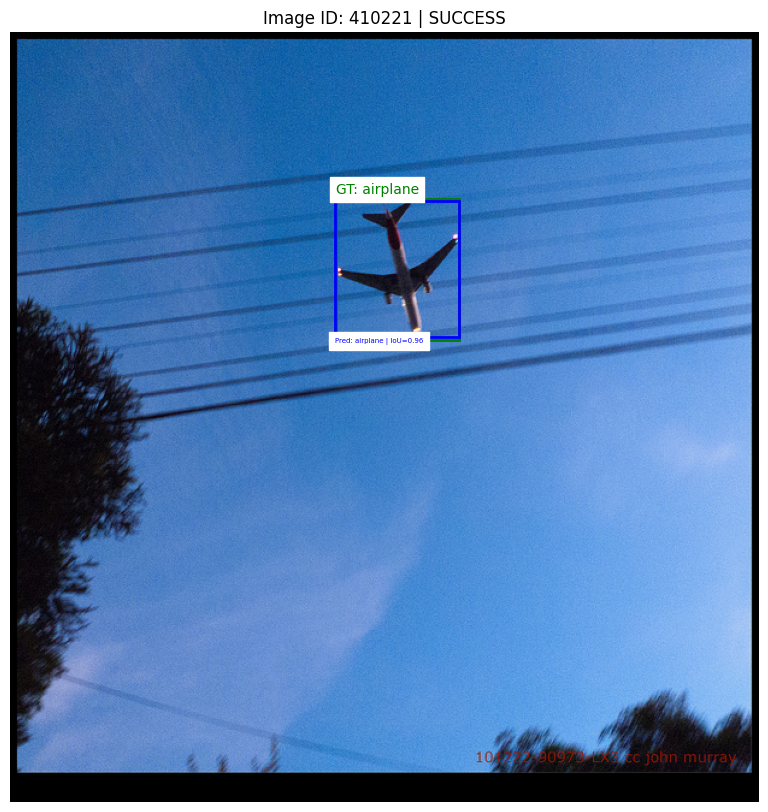

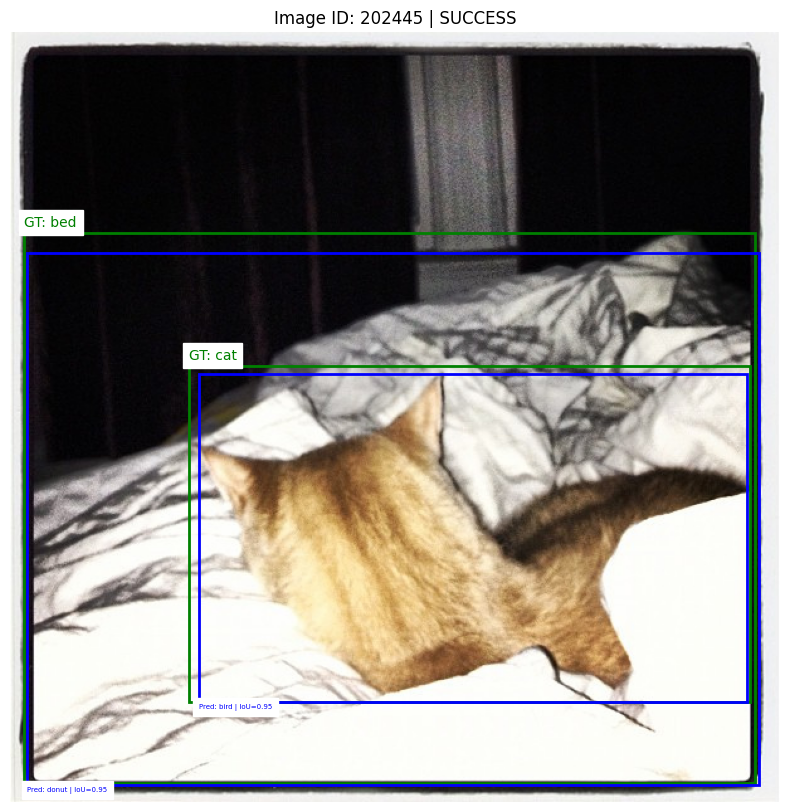

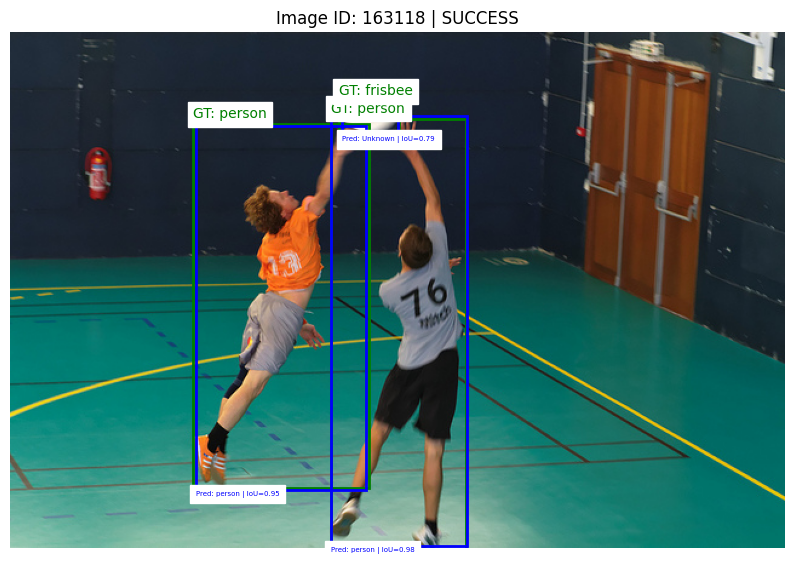

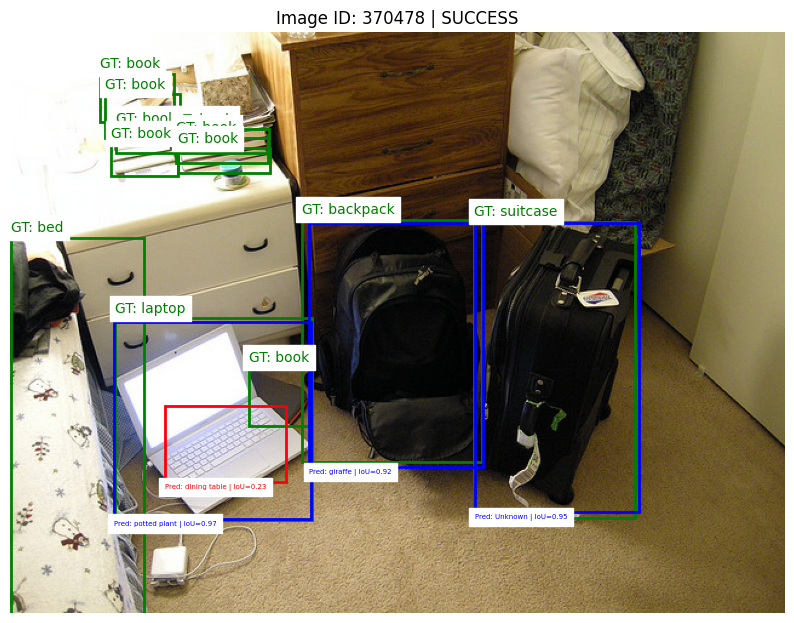

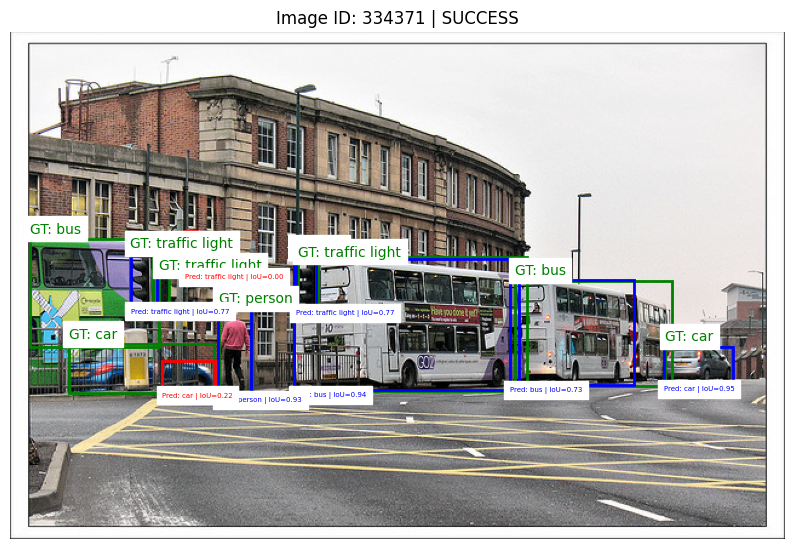

In [19]:
import random
from PIL import Image

# Use only images that have predictions
img_ids = list(preds_by_img.keys())
random.shuffle(img_ids)

# Show 5 random predicted images
for img_id in img_ids[:5]:
    show_image_with_boxes(img_id, iou_threshold=0.5, score_threshold=0.3)


In [20]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

def register_hooks(model, layer_names):
    """
    Register hooks to extract activations from specific layers in a YOLOv8 model.
    
    Args:
        model: Ultralytics YOLO model (e.g., YOLO('yolov8n.pt'))
        layer_names: List of layer names to hook (match model.model.named_modules())
    
    Returns:
        Dictionary that will hold activations keyed by layer name.
    """
    activations = {}

    def get_hook(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook

    # model.model gives access to internal architecture
    for name, module in model.model.named_modules():
        if name in layer_names:
            module.register_forward_hook(get_hook(name))

    return activations


In [24]:
def plot_feature_maps(activations, layer_names, num_maps=4):
    for layer in layer_names:
        fmap = activations[layer].squeeze(0)  # remove batch dimension
        num_channels = fmap.shape[0]

        plt.figure(figsize=(12, 4))
        for i in range(min(num_maps, num_channels)):
            plt.subplot(1, num_maps, i + 1)
            plt.imshow(fmap[i].cpu().numpy(), cmap='viridis')
            plt.axis('off')
            plt.title(f'{layer} [{i}]')
        plt.suptitle(f'Feature Maps from Layer: {layer}', fontsize=14)
        plt.tight_layout()
        plt.show()


In [25]:
def visualize_feature_maps(yolo_model, image, layer_names):
    """
    Visualize feature maps for a given PIL image and a YOLOv8 model.
    Args:
        yolo_model: YOLO object (from ultralytics, e.g., YOLO('yolov8n.pt'))
        image: PIL.Image object
        layer_names: list of layer names from yolo_model.model
    """
    yolo_model.eval()

    # Access inner PyTorch model and register hooks
    activations = register_hooks(yolo_model, layer_names)

    # Preprocess image (resize to YOLO input size)
    transform = T.Compose([
        T.Resize((640, 640)),
        T.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    # Inference through internal model (not yolov8's high-level API)
    with torch.no_grad():
        _ = yolo_model.model(img_tensor)

    # Plot feature maps
    plot_feature_maps(activations, layer_names)


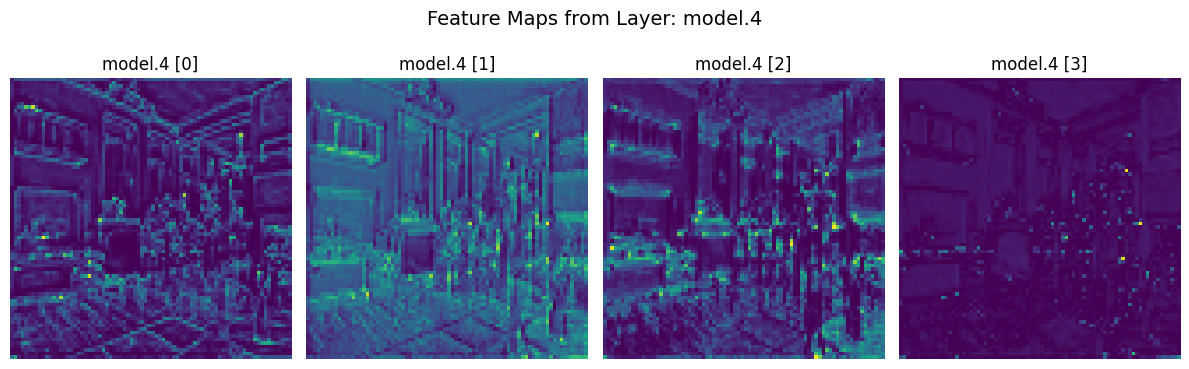

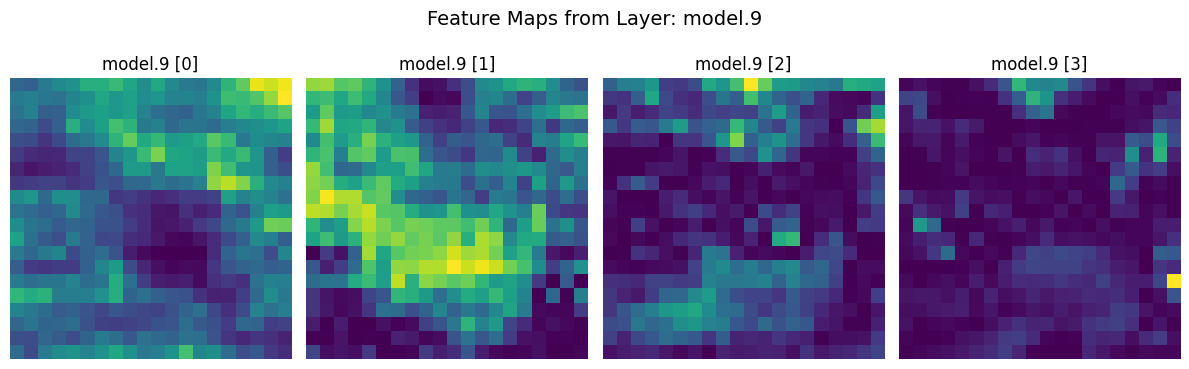

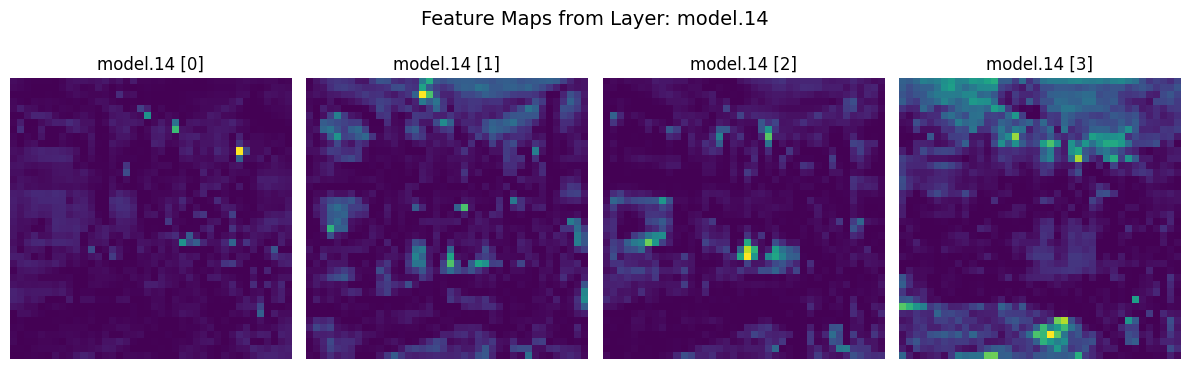

In [28]:
from ultralytics import YOLO
from PIL import Image

# Load YOLOv8 model
model = YOLO('yolov8n.pt')
model.eval()

# Load COCO image from Kaggle
image = Image.open("/kaggle/input/coco-2017/val2017/val2017/000000000139.jpg").convert("RGB")

# Choose 3 internal layers to visualize (use model.model.named_modules() to inspect)
layer_names = [
    "model.4",
    "model.9",
    "model.14"
]

# Run your visualization
visualize_feature_maps(model, image, layer_names)
